In [1]:
import sys
print(sys.executable)

C:\Users\Aquaregis32\.conda\envs\PyML32\python.exe


# Boston Housing Price Prediction

### Loading libraries

In [19]:
## Basics
import numpy as np
import pandas as pd
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

## Regression using scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso 

## Setup
warnings.filterwarnings('ignore') 
%matplotlib inline
%autosave 10

Autosaving every 10 seconds


### Loading data

In [3]:
boston = pd.read_csv("data/BostonHousing.csv")
print(boston.columns.values)
boston.head()

['crim' 'zn' 'indus' 'chas' 'nox' 'rm' 'age' 'dis' 'rad' 'tax' 'ptratio'
 'b' 'lstat' 'medv']


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
print(boston.isnull().sum())
print("\n")
print(boston.info())

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB
None


In [5]:
X = boston.drop("medv", axis = 1).values
y = boston["medv"].values.reshape(-1,1)
print(X.shape,y.shape)

(506, 13) (506, 1)


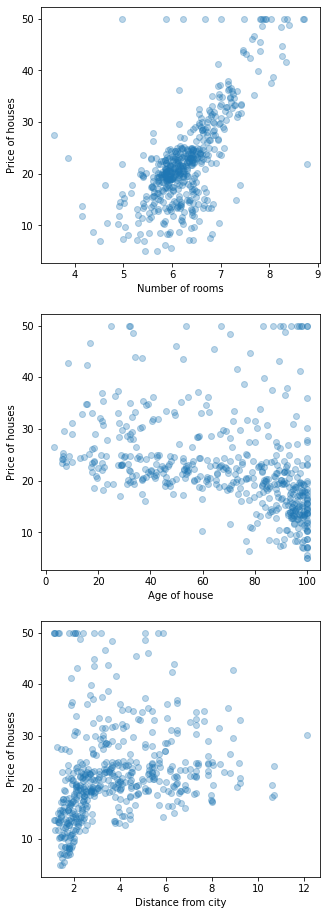

In [6]:
fig = plt.figure(figsize=(5,16))

ax1 = fig.add_subplot(3,1,1) 
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

ax1.scatter(X[:,5], y, alpha = 0.3) 
ax1.set_xlabel("Number of rooms")
ax1.set_ylabel("Price of houses")

ax2.scatter(X[:,6], y, alpha = 0.3) 
ax2.set_xlabel("Age of house")
ax2.set_ylabel("Price of houses")

ax3.scatter(X[:,7], y, alpha = 0.3) 
ax3.set_xlabel("Distance from city")
ax3.set_ylabel("Price of houses")

plt.show()

Fitting model using only room information

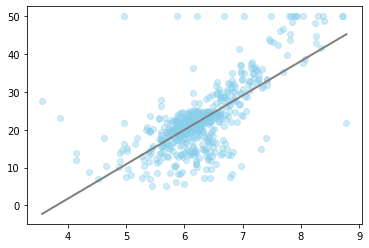

In [7]:
X_rm = X[:,5].reshape(-1,1)
lreg_rm = LinearRegression()
lreg_rm.fit(X_rm,y)

prediction_space = np.linspace(min(X_rm),max(X_rm))
plt.scatter(X_rm, y, color = 'skyblue', alpha = 0.4)
plt.plot(prediction_space, lreg_rm.predict(prediction_space), color = 'gray', linewidth = 2)

### Modelling

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=193)

In [9]:
lreg = LinearRegression()

In [10]:
lreg.fit(X_train, y_train)

LinearRegression()

In [11]:
y_pred_train = lreg.predict(X_train)
y_pred_test = lreg.predict(X_test)

In [12]:
print("""Scores
Training data: {train}%
MSE          : {MSE_train}
Testing data : {test}%
MSE          : {MSE_test}""".format(train = round(lreg.score(X_train, y_train)*100,2),
                                    test = round(lreg.score(X_test,y_test)*100,2),
                                    MSE_train = round(np.sqrt(metrics.mean_squared_error(y_pred_train,y_train)),2),
                                    MSE_test = round(np.sqrt(metrics.mean_squared_error(y_pred_test,y_test)),2)))

Scores
Training data: 72.19%
MSE          : 4.72
Testing data : 77.16%
MSE          : 4.64


Cross-validation score

In [13]:
cv_res = cross_val_score(lreg, X, y, cv = 5)
print("""Cross validation scores for 5-fold CV: {}
Cross validation mean score          : {}""".format(cv_res,np.mean(cv_res)))

Cross validation scores for 5-fold CV: [ 0.63919994  0.71386698  0.58702344  0.07923081 -0.25294154]
Cross validation mean score          : 0.35327592439587735


#### Ridge regression for regularization

In [15]:
ridge = Ridge(alpha = 0.1, normalize = True)

In [16]:
ridge.fit(X_train, y_train)

Ridge(alpha=0.1, normalize=True)

In [17]:
right_pred = ridge.predict(X_test)

In [18]:
ridge.score(X_test, y_test)

0.7618525671655647

###### Identifying the best value for alpha 

In [51]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

In [61]:
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []
for alpha in alpha_space:
    ridge.alpha = alpha
    ridge_cv_scores = cross_val_score(ridge, X, y, cv = 10)
    ridge_scores.append(np.mean(ridge_cv_scores))
    ridge_scores_std.append(np.std(ridge_cv_scores))

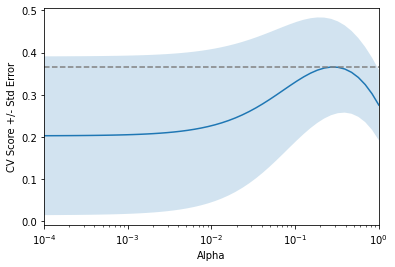

In [62]:
display_plot(ridge_scores, ridge_scores_std)

#### Lasso regression for feature selection

In [20]:
lasso = Lasso(alpha = 0.1, normalize = True)

In [21]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, normalize=True)

In [22]:
lasso_pred = lasso.predict(X_test)

In [23]:
lasso.score(X_test, y_test)

0.6299612753509112

Identifying most important features

In [25]:
lasso_coef = lasso.fit(X, y).coef_

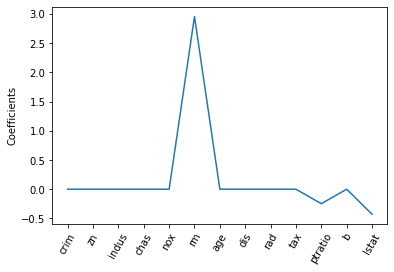

In [50]:
names = [x for x in boston.columns.values[0:13]]
plt.clf()
plt.plot(range(len(names)), lasso_coef)
plt.xticks(range(len(names)), names, rotation = 60)
plt.ylabel("Coefficients")
plt.show()